In [1]:
filename = "/home/nbiescas/Desktop/CVC/Omniglot/omniglot.npz"
import numpy as np
import random
import webbrowser
import time
import networkx as nx
import matplotlib.pyplot as plt
load_data = np.load(filename, allow_pickle=True, encoding='latin1')


train_set = load_data['train']
valid_set = load_data['valid']
test_set = load_data['test']

def generate_grid():
    url = r"D:\NIL\OMNIGLOT\sample.svg"
    for _ in range(5):
        s_list = []
        for i in range(3):
            for j in range(3):
                s_list.append((random.choice(train_set), (i, j)))

        matrix = make_grid_svg(s_list=s_list)
        draw_strokes(matrix)
        webbrowser.open(url)
        time.sleep(0.5)

In [2]:
import dgl
import torch
def read_npz_files(filename):
    if (filename.split('.')[-1] != 'npz'):
        raise ValueError("Invalid file format")
    load_data = np.load(filename, allow_pickle=True, encoding='latin1')
    return load_data['train'], load_data['valid'], load_data['test']

def read_letters(data):
    node_feat = np.zeros((len(data), 2)) # features (num_nodes x 2) 2 because the features are the cordinates of each node
    adj_matrix = np.zeros((len(data), len(data)))
    x = 0
    y = 0
    for node_id, row in enumerate(data):
        x += row[0]
        y -= row[1]
        node_feat[node_id] = [x, y]
        if (node_id != 0):
            _, _, previous_lift = data[node_id - 1]
            if (previous_lift == 1):
                continue
            adj_matrix[node_id][node_id - 1] = 1
            adj_matrix[node_id - 1][node_id] = 1

    src, dst = np.nonzero(adj_matrix)
    g = dgl.graph((src, dst))
    g.ndata['feat'] = torch.from_numpy(node_feat)

    #G = nx.from_numpy_array(am) # Createa a graph from an adjacency matrix
    #nx.set_node_attributes(G, node_label, 'position')

    return g

In [45]:
import networkx as nx
import matplotlib.pyplot as plt

def plot_graph(G, position, ax):
    #fig, ax = plt.subplots(figsize=(5, 7))
      
    # Draw nodes and edges
    nx.draw_networkx_nodes(G, ax=ax, pos=position)
    nx.draw_networkx_edges(G, ax=ax, pos=position)
    
    # Add labels
    node_labels = {n: n for n in G.nodes()}
    nx.draw_networkx_labels(G, ax=ax, pos=position, labels=node_labels)
    
    # Customize plot appearance
    ax.set_title("Graph Visualization")
    ax.set_xlabel("X Axis")
    ax.set_ylabel("Y Axis")
    
    plt.tight_layout()

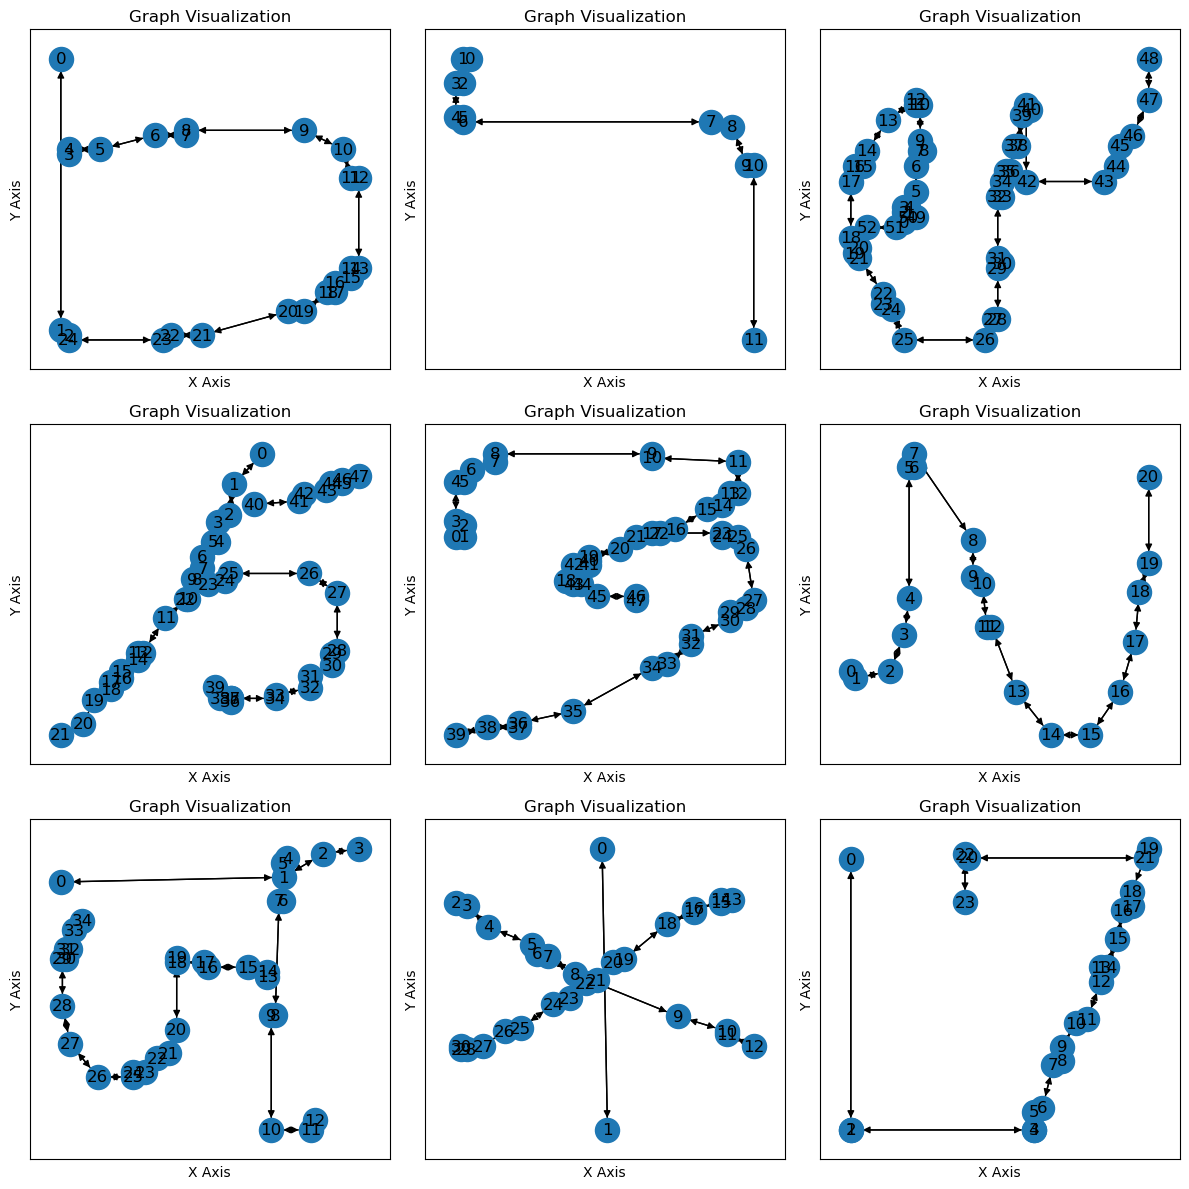

In [51]:
fig, idx = plt.subplots(3, 3, figsize=(12, 12))
for i in range(3):
    for j in range(3):
        axis = idx[i, j]
        sample = train_set[random.randint(0, len(train_set))]
        dgl_graph = read_letters(sample)
        G = dgl.to_networkx(dgl_graph)
        features = {node_id:row for node_id, row in enumerate(dgl_graph.ndata["feat"].numpy())}
        plot_graph(G, features, axis)

plt.show()

#draw_strokes(sample)
#webbrowser.open(r"D:\NIL\OMNIGLOT\sample.svg")

In [4]:
trainset, validset, testset = read_npz_files(filename)

Train_Graphs = [read_letters(graph) for graph in trainset]
Valid_Graphs = [read_letters(graph) for graph in validset]
Test_Graphs  = [read_letters(graph) for graph in testset]

In [5]:
#Divide in train, test, validation.
import torch
from torch.utils.data import DataLoader

def collate(graphs):
    batched_graph = dgl.batch(graphs)
    return batched_graph

trainset, validset, testset = read_npz_files(filename)

Train_Graphs = [read_letters(graph) for graph in trainset]
Valid_Graphs = [read_letters(graph) for graph in validset]
Test_Graphs  = [read_letters(graph) for graph in testset]

# Define the three dataloaders. Train data will be shuffled at each epoch
train_loader = DataLoader(Train_Graphs, batch_size=32, shuffle=True,
                         collate_fn=collate)
valid_loader = DataLoader(Valid_Graphs, batch_size=32, collate_fn=collate)
test_loader = DataLoader(Test_Graphs, batch_size=32, collate_fn=collate)

In [12]:
train_loader.__len__()

938